In [136]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline

def ind2onehot(indep_ind, k):
    indep = indep_ind.shape[0]
    out = np.zeros((indep, k))
    out[np.arange(indep), indep_ind] = 1
    return out

def softmax(xs):
    sps = xs.shape
    num = np.exp(xs)
    den = np.sum(num, axis=1).reshape(sps[0], 1)
    return num/den

def np_random_choice_multi(ps):
    ''' Essentially same implementation found on Stack Overflow:
        1. https://stackoverflow.com/questions/47722005/vectorizing-numpy-random-choice-for-given-2d-array-of-probabilities-along-an-a
          - questioner: thanabrooks (https://stackoverflow.com/users/4176597/ethanabrooks)
          - answerer: Divakar (https://stackoverflow.com/users/3293881/divakar)
        2. https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s
          - questioner: max_max_mir (https://stackoverflow.com/users/3508752/max-max-mir)
          - answerer: Warren Weckesser (https://stackoverflow.com/users/1217358/warren-weckesser)
        
        According to the below article
        * https://legalict.com/2016/01/07/what-is-the-license-status-of-stackoverflow-code-snippets/
        such a simple code snippet seems NOT protected by copyright, but in case, I noted here.
        
        License on Code snoppets on Stack Overflow is explained below:
        * https://stackoverflow.com/legal/terms-of-service/public#licensing
    '''
    indep, k = ps.shape
    threshold = np.random.uniform(0,1, indep).reshape(indep, 1)
    integrals = ps.cumsum(axis=1)
    samples = np.argmax(integrals>threshold, axis=1)
    return samples
    
#####

class Environment():
    ''' prototype'''
    def __init__(self):
        self.name = None
    def step(self, a):
        return reward

class k_armed_Bandit(Environment):
    def __init__(self, k, indep=2000, m=0):
        '''
        seld._qs.shape = (indep, k) # indep個のk-bandits 
        '''
        self.k = k
        self.indep = indep
        self.m = m
        self._ms = np.random.randn(k*indep).reshape(indep, k) + m # 値はわからない設定
        self.name = 'k={}, offset={}, indep={}'.format(k, m, indep)
        
    def step(self, a, dev=1):
        '''
        報酬を返す, 報酬はself._msを中心とした分散devのガウス分布からサンプル
          input : a.shape = (indep, 1) # indep個のaction
          output.shape = (indep, )
        '''
        return np.random.normal(self._ms[a==np.tile(np.arange(self.k), (self.indep, 1))], dev)
        
#####

class Agents():
    ''' agents play `indep`-numbers of bandits. '''
    def __init__(self, policy):
        self.policy = policy
    def play(self, indep):
        return self.policy.sample(indep)
    
#####
    
class Policy():
    ''' prototype'''
    def __init__(self, env):
        self.env = env
        self.action_space = np.arange(env._ms.shape[1])
        self.k, self.indep = env.k, env.indep
        self.t = 0
    def update(self, indep_r_np, a):
        pass
    def sample(self, indep):
        indep_inds = None
        return ind2onehot(indep_inds, k)
    
class Epsilon_Greedy(Policy):
    def __init__(self, env, epsilon):
        super(Epsilon_Greedy, self).__init__(env)
        self.epsilon = epsilon
        self.Q = np.zeros(env.indep*env.k).reshape(env.indep, env.k)
        self.N = np.zeros(env.indep*env.k).reshape(env.indep, env.k) # これで各aのtを数える
        self.name = r'($\epsilon={}$ $\epsilon$-greedy)'.format(epsilon)
        if env.m != 0:
            self.name+='(reward+{})'.format(env.m)
        
    def update(self, indep_r_np, a):
        ''' Q = \sum r /T に基づいた反復実装 T~N '''
        self.N[a==np.tile(np.arange(self.k), (self.indep, 1))] += 1  # a に対応する成分のみ+1
        self.Q[a==np.tile(np.arange(self.k), (self.indep, 1))] *= (1-
                                                                   1/self.N[a==np.tile(np.arange(self.k), (self.indep, 1))])
        self.Q[a==np.tile(np.arange(self.k), (self.indep, 1))] += indep_r_np/self.N[a==np.tile(np.arange(self.k), (self.indep, 1))]
        
    def sample(self, indep=None):
        '''
        numpy並列化用のe-greedy, output = (indep, k) # indep毎のaのone-hot vector
        '''
        if indep is None:
            indep = self.indep
        random_bools = np.random.rand(indep) < self.epsilon # (indep, )
        #print("random_bools succeed")
        greedy_bools = 1 - random_bools # (indep, )
        
        random_actions = np.random.choice(self.action_space, indep) # (indep, 1)
        greedy_actions = np.argmax(self.Q, axis=1) # (indep, 1)
        
        a = random_bools*random_actions + greedy_bools*greedy_actions
        k = len(self.action_space)
        
        self.t += 1
        return a.reshape(indep, 1)
    
class Softmax(Policy):
    def __init__(self, env, eta, baseline_applied=False):
        super(Softmax, self).__init__(env)
        self.eta = eta
        self.H = np.zeros(env.indep*env.k).reshape(env.indep, env.k)
        self.Rbar = np.zeros(env.indep)
        self.name = r'($\eta={}$ softmax)'.format(eta)
        self.baseline_applied = baseline_applied
        if env.m != 0:
            self.name+='(reward+{})'.format(env.m)
        if baseline_applied:
            self.name += '(+baseline)'
        
    def calc_barR_tplus1(self, indep_r_np):
        self.Rbar *= (1-1/self.t)
        self.Rbar += indep_r_np/self.t
        
    def update(self, indep_r_np, a):
        B = 0
        if self.baseline_applied:
            self.calc_barR_tplus1(indep_r_np)
            B += self.Rbar
        q = (indep_r_np - B).reshape(self.indep, 1)
        bool_match = (a==np.tile(np.arange(self.k), (self.indep, 1)))
        dirac = np.zeros((self.indep, self.k))
        dirac[bool_match] += 1
        self.H += self.eta*q*(dirac-softmax(self.H))
    
    def sample(self, indep=None):
        if indep is None:
            indep = self.indep
        a = np_random_choice_multi(softmax(self.H))
        k = len(self.action_space)
        self.t += 1
        return a.reshape(indep, 1)
    
    
def run_trial(ax, env, agt, N_trials=3000):
    k, indep = env.k, env.indep
    r_history = []
    for tau in range(N_trials):
        a = agt.policy.sample()
        r = env.step(a)
        agt.policy.update(r, a)
        #
        r_history.append(r)
    
    rs= np.array(r_history)
    ax.set_xlabel("time")
    ax.set_ylabel("rewards average")
    ax.set_title("{} indep (k={})-bandits, {}-trial averages".format(env.indep, env.k, N_trials))
    ax.plot([np.mean(rs[t,:]) for t in range(1,N_trials)], 
            label=agt.policy.name, alpha=0.5)
    


## 9-1. 多腕バンディット問題
強化学習の方法の簡単版に**多腕バンディット問題(multi-armed Bandit Problem)** というものがあります。まずはこの問題から説明することで、強化学習の方法がどういうものかという感覚を説明したいと思います。

### 設定

さて、突然ですがあなたは今、とあるカジノにやってきたと想像して下さい。目の前には $k$ 個の異なるスロットマシンがあるとします。

![alt](b1.jpg)

このスロットマシンは特殊で、タダで回すことができる代わりに

* 正の報酬 → お金を貰える
* 負の報酬 → お金を支払う

というものだとします。このとき、**どのスロットを回すべきか** というのは誰もが考える、解くべき重要なタスクです。実際にここで仮想的に `k=10` 個のスロットを作って回してみます：

In [3]:
env = k_armed_Bandit(k=10, indep=1) # 10個のスロットを1組作成
for t in range(10):
    a = np.random.randint(10)
    print("%d-th slot"%a, env.play(a)) # 結構上下する

7-th slot [2.12991484]
4-th slot [-2.32984784]
0-th slot [0.12454863]
0-th slot [0.93040237]
6-th slot [0.53414869]
7-th slot [0.8425599]
8-th slot [-2.01895156]
2-th slot [1.04883185]
0-th slot [-1.25117307]
2-th slot [0.34874849]


いまいち何番目が良いか、これだけだとわかりませんから、各`a`番目のスロットを`1000`回ずつ引いて、出た報酬をプロットしてみます：

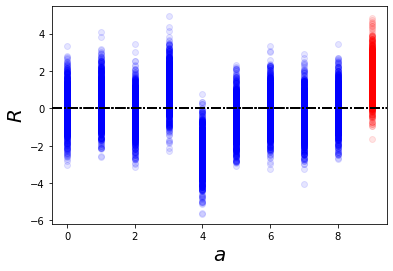

In [4]:
N_trials= 1000
plt.xlabel(r"$a$", fontsize=20)
plt.ylabel(r"$R$", fontsize=20)
for k in range(10):
    rs = []
    for t in range(N_trials):
        rs.append(env.play(k))
    if k==np.argmax(env._ms):
        color='red'
    else:
        color='blue'
    plt.scatter(k*np.ones(N_trials), rs, alpha=0.1, color=color)
    plt.axhline(y=0, xmin=0, xmax=30, color='black', ls="-.")

縦軸 $R$ は得られた報酬、横軸 `a` はスロットの番号を表します。赤くプロットされた `a` が最良の報酬を与えるスロットです。この最良のスロットだけ引き続ければ大数の法則によって、**あなたは必ず勝てます**。おめでとうございます！

...

まてよ、実際に総当りで1000 x 10 回もスロットを回す勇気が僕にはあるだろうか…いや、ない。

### 目的
そういうわけで、このゲームを手堅く攻略する方法を考えましょうとなるわけです。ポイントは

* スロットの報酬のばらつきは、背後で設定されているが、エージェント（プレイヤー）にとっては未知
* エージェントは $k$ 個のスロットのどれでも、何回でも回して良い
* その上で、なるべく少ない試行で最良のスロットを選びたい

ということになります。基本的には**何度か試してみて、よく当たる台を選ぶ**、という作戦に尽きるのですが、それをいろんな考え方で実行するのが強化学習ともいえるでしょう。

### 定義
まず幾つか重要な概念を定義しておきます。

#### 行動 $a$ と方策 $\pi(a)$

![alt](b2.jpg)

エージェントが取る行動は、正味、スロットマシンを選ぶことなので、選ばれたスロットマシンの番号 $a$ を**行動(action)**と呼ぶことにします。行動はエージェントの気分に左右されるので、それを反映した確率（これを**方策(policy)**といいます）に従うとします：

$$
a \sim \pi(a)
$$

#### 報酬 $r$ と報酬環境の確率

![alt](b3.jpg)

各スロットマシンは番号 $a$ でラベル付けされており、隠れた設定値 $\mu_a$ を持つとします。その上で、番号 $a$ のスロットマシンを回して得られる報酬 $r$ は中心 $\mu_a$、分散 $1$ のガウス分布に従うものとします：

$$
r(a=\text{番号})
\sim
\mathcal{N}(\mu_a, 1)
$$

つまり、最良のスロットマシンは、最大の $\mu_a$ を持つものです。


> ちなみに各 $\mu_a$ は、`env = k-armed bandit()` などとした時に標準正規分布から独立にサンプルして設定しています。また、このようにガウス分布を用いた単純な定義では記述できないようなスロットマシンを考えることもあると思います。その場合でも、$r(a=\text{番号})$ は何らかの確率に従う確率変数、とすれば以下の議論はそのまま適用できるはずです。

### 価値関数に基づく最適化



#### 価値関数
行動 a の**価値(value)**は、その行動を取ったときの報酬の期待値

$$
q_*(a) = \langle r(a) \rangle_{\mathcal{N}(\mu_a, 1)}
$$

で定義します。価値がわかれば一番価値の大きな台でプレイするのが良いでしょう。実際、今の場合、$r(a) \sim \mathcal{N}(\mu_a, 1)$だから定義により $q_*(a) = \mu_a $ なので、バンディットを初期化した時に$\mu_a$として最大値を取るものを選び続ければよい、ということになります。

何度かこのゲームをプレイすると「記録」

$$
\{A_1, r(A_1)\}, \{A_2, r(A_2)\}, \dots, \{A_T, r(A_T)\}
$$

を貯めることができます。これが、教師あり学習や教師なし学習の際に**学習データ**だったものです。このとき、
* $T_a$: $T$回の施行のなかで $a$ を訪問した回数、$\sum_a T_a = T$

とすると、$q_*(a)$ の近似として「記録」の中で $a$ にトライした時に得た報酬の平均値

$$
Q_{T}(a) = \frac{1}{T_a}\sum_{t=1}^{T}  r(A_t) \cdot 1_{A_t =a} \approx q_*(a)
$$

を考えることができます。これに基づいた次の時刻 $T+1$ での方策を幾つか考えます。





#### 貪欲な方策
まず最も素朴なのは、「これまでの記録上最も成績の良かった台**のみ**を回す」と言う手法で、これを**貪欲法(greedy action selection)**といいます。貪欲法に則った方策

$$
\pi_\text{greedy}^T(a) = 
1_{Q_T(a) = \max_a' Q_T(a') }
$$

を貪欲な方策と言います。

#### $\epsilon$-貪欲な方策
確率 $0 <\epsilon<1 $ だけ全くランダムに、確率 $1-\epsilon$ で貪欲になる方策を $\epsilon$-貪欲(**$\epsilon$-greedy**)な方策 といいます：

$$
\pi_{\epsilon\text{-greedy}}^T(a) = \left\{ \begin{array}{ll}
1_{Q_T(a) = \max_a' Q_T(a') } & prob = 1- \epsilon \\
\frac{1}{k} & prob=\epsilon \\
\end{array} \right.
$$

こちらは、ちょっとは別の台も回しに行こうという方策です。$\epsilon=0$ で貪欲方策に戻ります。




#### 実験

CPU times: user 12.2 s, sys: 161 ms, total: 12.3 s
Wall time: 12.4 s


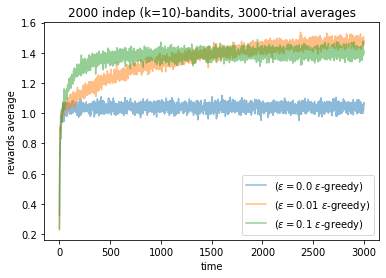

In [88]:
%%time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
env = k_armed_Bandit(k=10, indep=2000) # 10台のスロットマシンを独立に2000組用意

agt = Agents(policy=Epsilon_Greedy(env, epsilon=0.))
run_trial(ax=ax, env=env, agt=agt)

agt = Agents(policy=Epsilon_Greedy(env, epsilon=0.01))
run_trial(ax=ax, env=env, agt=agt)

agt = Agents(policy=Epsilon_Greedy(env, epsilon=0.1))
run_trial(ax=ax, env=env, agt=agt)

plt.legend(loc='best')

このように、今回のケースだと
* $\pi_\text{greedy}$の報酬平均 $\approx 1$
* $\pi_{0.1\text{-greedy}}$の報酬平均 $\approx 1.35$
* $\pi_{0.01\text{-greedy}}$の報酬平均 $\approx 1.4$

のあたりに収束してゆくのがわかります。貪欲な方策よりも遊びを持たせた方策のほうが最終的に上手く行っているのがわかります。また、遊びが大きい($\epsilon=0.1$)と早く大きな return を得ることができますが、最終的には程々の遊び($\epsilon=0.01$)が最良となりました。

#### 関連する話題
Optimistic初期値やUCBとか

### Expected returnに基づく最適化

#### Expected return
どのように $a$ を選ぶべきか、が解きたい問題なので、価値について、更に方策 $\pi$ についても期待値を取った

$$
J(\pi) = \big\langle q_*(a) \big\rangle_{a \sim \pi(a)}
$$

を最大化する行動 $a$ についての確率 $\pi$ を探すのが最終目標とも言えます。$J(\pi)$ を **expected return** といいます。価値関数の推定を飛ばして、最初から　$\pi$ についての最適化

$$
\pi \leftarrow \pi + \eta \nabla_\pi J(\pi)
$$

を行って最終的に得られる方策も良い方策であると言えそうです。


#### Softmax方策
$\pi$ を微分可能にしたいのですが、$\pi(a)$ をそのまま勾配更新すると確率解釈から外れてしまう可能性があります。そういう場合は、$\pi(a)$ が何らかの関数 $H(a)$ についてsoftmax関数の形で書けている

$$
\pi_H(a)=
\frac{e^{H(a)}}{\sum_{a'}e^{H(a')}}
$$

と思って、 

$$
\forall a,
\quad
H_{t+1}(a)=
H_t(a) + \eta \nabla_{H_t(a)} J(\pi_{H_t})
$$

の更新を考えます。二項目の微分値は以下のように変形すると見通しが良いです。最後の変形で log の微分値 $\nabla_{H(a)} \log \pi_H(a') = \nabla_{H(a)} \Big(H(a') - \log \sum_{a'} e^{H(a')} \Big) = \Big( 1_{a'=a} - \underbrace{\frac{e^{H(a')}}{\sum_{a''} e^{H(a'')}}}_{\pi_H(a')} \Big)$ を使います：

$$
\left. \begin{array}{ll}
{\color{red}{\nabla_{H(a)}}} J(\pi_H)&=
 \sum_{a'} q_*(a') \underbrace{{\color{red}{\nabla_{H(a)}}}\pi_H(a')}_{\color{blue}{\pi_H(a') \nabla_{H(a)} \log \pi_H(a')}} \\
 &= \langle q_*(a') {\color{blue}{\nabla_{H(a)} \log \pi_H(a')}} \rangle_{\color{blue}{a' \sim \pi_H}}\\
 &= \big\langle q_*(a') \big( 1_{a'=a} - \pi_H(a') \big) \big\rangle_{a' \sim \pi_H}
\end{array} \right.
$$

この更新を使いつつバンディット問題を解かせ続けると、やはり良い方策にたどり着くと期待されます。

#### 実験

CPU times: user 13 s, sys: 253 ms, total: 13.2 s
Wall time: 13.3 s


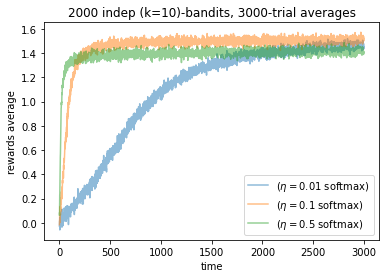

In [145]:
%%time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
env = k_armed_Bandit(k=10, indep=2000) 

agt = Agents(policy=Softmax(env, eta=0.01))
run_trial(ax=ax, env=env, agt=agt)

agt = Agents(policy=Softmax(env, eta=0.1))
run_trial(ax=ax, env=env, agt=agt)

agt = Agents(policy=Softmax(env, eta=0.5))
run_trial(ax=ax, env=env, agt=agt)

plt.legend(loc='best')

#### ベースラインの導入
突然ですが、**全てのスロットマシンの報酬平均値が+4される**大サービスが行われたとします。このとき、価値に基づく手法は：

CPU times: user 2.46 s, sys: 16.2 ms, total: 2.47 s
Wall time: 2.48 s


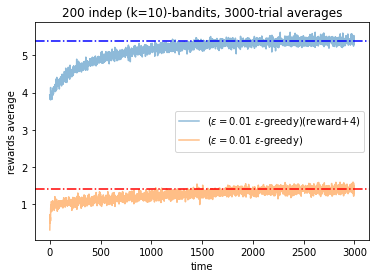

In [141]:
%%time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

env = k_armed_Bandit(k=10, indep=200, m=4) 
agt = Agents(policy=Epsilon_Greedy(env, epsilon=0.01))
run_trial(ax=ax, env=env, agt=agt)

env = k_armed_Bandit(k=10, indep=200) 
agt = Agents(policy=Epsilon_Greedy(env, epsilon=0.01))
run_trial(ax=ax, env=env, agt=agt)

ax.axhline(y=5.4, xmin=0, xmax=3000, color='blue', ls="-.")
ax.axhline(y=1.4, xmin=0, xmax=3000, color='red', ls="-.")

plt.legend(loc='best')

のように、もとの報酬平均に +4 した値にきちんと収束しています。一方で、softmax方策では

CPU times: user 2.06 s, sys: 17.8 ms, total: 2.08 s
Wall time: 2.08 s


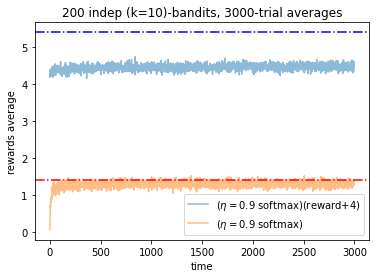

In [144]:
%%time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

env = k_armed_Bandit(k=10, indep=200, m=4) 
agt = Agents(policy=Softmax(env, eta=0.9))
run_trial(ax=ax, env=env, agt=agt)

env = k_armed_Bandit(k=10, indep=200) 
agt = Agents(policy=Softmax(env, eta=0.9))
run_trial(ax=ax, env=env, agt=agt)

ax.axhline(y=5.4, xmin=0, xmax=3000, color='blue', ls="-.")
ax.axhline(y=1.4, xmin=0, xmax=3000, color='red', ls="-.")

plt.legend(loc='best')

このように、ボーナス無しの場合の+4よりやや下に平均報酬が出てしまいます。なぜこうなるかというと、

$$
H_{t+1}(a)=
H_t(a) + \eta \underbrace{\nabla_{H_t(a)} J(\pi_{H_t})}_{\big\langle q_*(a') \big( 1_{a'=a} - \pi_H(a') \big) \big\rangle_{a' \sim \pi_H}}
$$

の $q_*(a)$ を、それまで得られた報酬で近似するので、報酬の絶対値が大きいと、$J(\pi)$の勾配の分散が大きくなって正しい勾配に収束してくれないからです。

そこで導入されるのが **ベースライン** というものです。expected return の勾配ですが

$$
{\color{red}{\nabla_{H(a)}}} J(\pi_H)=
 \sum_{a'} \underbrace{q_*(a')}_{=: q_*(a') - B} {\color{red}{\nabla_{H(a)}}}\pi_H(a')
$$

という置き換えをしても、$B$が微分に関係ない定数なら $- B \nabla \underbrace{\sum_{a'}\pi_H(a')}_{1} = 0$ なので勾配は不変となります。一方でうまい $B$ を選べば、勾配の分散をへらす効果が期待できます。普通はベースラインにはそれまでに得た総報酬を使うのが一般的なようです：

$$
B = \bar{R} = \sum_{a} Q_T(a)
$$

ベースラインを入れると、きちんと+4の総報酬を得られるようになります：


CPU times: user 3.05 s, sys: 17.4 ms, total: 3.07 s
Wall time: 3.08 s


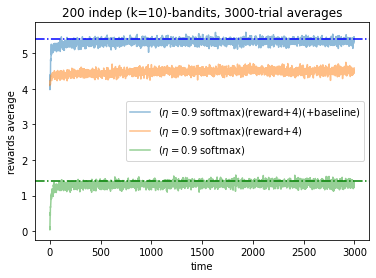

In [148]:
%%time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

env = k_armed_Bandit(k=10, indep=200, m=4) 

agt = Agents(policy=Softmax(env, eta=0.9, baseline_applied=True))
run_trial(ax=ax, env=env, agt=agt)

agt = Agents(policy=Softmax(env, eta=0.9))
run_trial(ax=ax, env=env, agt=agt)

env = k_armed_Bandit(k=10, indep=200) 
agt = Agents(policy=Softmax(env, eta=0.9))
run_trial(ax=ax, env=env, agt=agt)

ax.axhline(y=5.4, xmin=0, xmax=3000, color='blue', ls="-.")
ax.axhline(y=1.4, xmin=0, xmax=3000, color='green', ls="-.")

plt.legend(loc='best')

### Comments on the licensed source code used in this subsection

#### Attribution of the function `np_random_choice_multi`

In this notebook, the implementation of

* function: `np_random_choice_multi`

is essentially same as ones found on Stack Overflow:
1. https://stackoverflow.com/questions/47722005/vectorizing-numpy-random-choice-for-given-2d-array-of-probabilities-along-an-a
    - questioner: thanabrooks (https://stackoverflow.com/users/4176597/ethanabrooks)
    - answerer: Divakar (https://stackoverflow.com/users/3293881/divakar)
2. https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s
    - questioner: max_max_mir (https://stackoverflow.com/users/3508752/max-max-mir)
    - answerer: Warren Weckesser (https://stackoverflow.com/users/1217358/warren-weckesser)

I wrote here in the way explained in https://stackoverflow.blog/2009/06/25/attribution-required/.

License on Code snoppets on Stack Overflow is explained in https://stackoverflow.com/legal/terms-of-service/public#licensing .

But, according to the article https://legalict.com/2016/01/07/what-is-the-license-status-of-stackoverflow-code-snippets/
, such a simple code snippet seems NOT protected by copyright, ... but in case, I noted here. ;)        
